# CIS 5450 Project: Machine Learning

*Due Date: 17th December 2022 at 11:59PM EST*

# Introduction

# 0 Setup

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import sequence
spark = SparkSession.builder.master("local[*]").getOrCreate()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 264 kB in 2s (155 kB/s)
Reading p

# 1 Data Loading and Preprocessing



## 1.1  Dataset 1: Open Food Facts (Baojia)
https://world.openfoodfacts.org/data


The dataset we used for this project is from Open Food Facts (https://world.openfoodfacts.org/data). We downloaded the most recent csv file and saved it into google drive. The full dataset contains 196 columns * 2640596 rows.

In [ ]:
# mount Google Grive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data from Google Drive

# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/partitions/p0.csv"
# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/100k.csv"
# path = "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv"
path = "drive/My Drive/545_project/data/en.openfoodfacts.org.products.csv" # wesley

df = spark.read.option("encoding", "UTF-8").option("delimiter", "\t").option("header", "True").csv(path)
df.show()
df.count()
# len(df.columns)

+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

2615635

To cleaning the rows, since we used the 'product_name' column as the key coulmn, we dropped any rows without a product name. We kept all the other 2547006 rows for now.





In [ ]:
# Drop rows with NaN in 'product_name' column and keep all the other rows for now. 

df = df.na.drop(subset=["product_name"])
df.show()
df.count()


+--------------------+--------------------+--------------+----------+--------------------+---------------+----------------------+--------------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------------+-------------+--------------------+--------------------+--------------------+-------+------------+----------+--------------------+-------------------------+-------------+----------------+----------------+---------+--------------+------------------------+------+-----------+---------------+-------------+----------------+----------------+-------------+--------------------+--------------------+-------------------------+----------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+------

2522649

To clean the columns, since the dataset contains a large number of NaN values, we set a threshold as 5% and dropped any columns with less than 5% coverage. We kept all the other 89 columns for now. Saved the new dataset into new_df.

In [ ]:
# Get the ratio of null values in each column
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

df.agg(*[count_not_null(c) for c in df.columns]).show()
exprs = [(count_not_null(c) / count("*")).alias(c) for c in df.columns]
df_null_ratio = df.agg(*exprs)
df_null_ratio.show()

+-------+-------+-------+---------+----------------+---------------+----------------------+------------+------------------------+------------+--------+---------+--------------+------------+--------------+-------+-----------+----------+---------------+-------------+-------+------------+----------+--------------------+-------------------------+------+-----------+---------+---------+--------------+------------------------+------+-----------+---------------+------+---------+--------------+------------+----------------+----------------+-------------------------+---------+------------+------+-----------+---------+------------+----------------+-------------+-----------+---------+--------------+------------+----------------+----------------+----------+-------------+-------------+-----------+----------------+--------------+-------+-----------+---------+-----------+--------------+--------------+--------------------+----------------+-----+------------------------+--------------+---------------+--

In [ ]:
# Drop columns with < 5% coverage
ratios = df_null_ratio.select(*[c for c in df.columns]).first()
cols_to_drop = [c for c in ratios.asDict() if ratios[c] < 0.05]
new_df = df.drop(*cols_to_drop)
new_df.show()
new_df.count()
len(new_df.columns)

## 1.2 Partitioning Open Food Facts Dataset (Wesley)


In [ ]:
# Row Partitioning
# Notes: please update the input_dir & output_dir before running
input_dir = "drive/My Drive/545_project/data/en.openfoodfacts.org.products.csv" # "/content/drive/MyDrive/2022 Fall CIS 545/CIS5450_project/data/en.openfoodfacts.org.products.csv"
output_dir = "drive/My Drive/545_project/data/partitions/"

num_partitions = 10

for r in range(num_partitions):
  print("working on ",r," th partition job")
  i = 0
  text = ""
  with open(input_dir, encoding='UTF-8') as f:
    header = f.readline()
    text += header

    while True:
      line = f.readline()
      if not line:
          break

      # The remainder (row index divide by num_partitions) would decide which partition file go to
      if i % num_partitions == r:
        text += line
      i += 1

  output_filename = output_dir + "p"+ str(r) +".csv"
  with open(output_filename, 'w', encoding='UTF8') as f:
    f.write(text)

working on  0  th partition job


FileNotFoundError: ignored

## 1.3 Dataset 2: Dietary Reference Intake from Wiki (Wesley)
https://en.wikipedia.org/wiki/Dietary_Reference_Intake

DRI provides several different types of reference values:

**Estimated Average Requirements (EAR)**, expected to satisfy the needs of 50% of the people in that age group based on a review of the scientific literature.

**Recommended Dietary Allowances (RDA)**, the daily dietary intake level of a nutrient considered sufficient by the Food and Nutrition Board of the Institute of Medicine to meet the requirements of 97.5% of healthy individuals in each life-stage and sex group. The definition implies that the intake level would cause a harmful nutrient deficiency in just 2.5%.

**Adequate Intake (AI)**, where no RDA has been established, but the amount established is somewhat less firmly believed to be adequate for everyone in the demographic group.

**Tolerable upper intake levels (UL)**, to caution against excessive intake of nutrients (like vitamin A) that can be harmful in large amounts. This is the highest level of sustained daily nutrient consumption that is considered to be safe for, and cause no side effects in, 97.5% of healthy individuals in each life-stage and sex group. 

**Acceptable Macronutrient Distribution Ranges (AMDR)**, a range of intake specified as a percentage of total energy intake. Used for sources of energy, such as fats and carbohydrates.


In [ ]:
table_DRI = pd.read_html('https://en.wikipedia.org/wiki/Dietary_Reference_Intake')
print(f'Total tables: {len(table_DRI)}')

In [ ]:
# There are 5 tables for this wiki page
# merge the first 2 table into nutrients_df
Vitamins_choline_df = table_DRI[0]
cols = ['Nutrient','Highest_EAR','Males_RDA','Females_RDA','UL','Unit','Top_common_sources']
Vitamins_choline_df.set_axis(cols, axis=1,inplace=True)
Vitamins_choline_df['Nutrient_type'] = 'vitamins_choline'
print(Vitamins_choline_df.shape)
# Vitamins_choline_df.head()

Minerals_df = table_DRI[1]
cols = ['Nutrient','Highest_EAR','Males_RDA','Females_RDA','UL','Unit','Top_common_sources']
Minerals_df.set_axis(cols, axis=1,inplace=True)
Minerals_df['Nutrient_type'] = 'minerals'
print(Minerals_df.shape)
# Minerals_df.head()

nutrients_df = pd.concat([Vitamins_choline_df, Minerals_df])
print(nutrients_df.shape)
nutrients_df.head()

In [ ]:
nutrients_df.info()
nutrients_df['Unit'].unique()

In [ ]:
# cleaning nutrients_df

# remove () [] 
for i in range(nutrients_df.shape[0]):
  if '[' in nutrients_df.iloc[i,3]: 
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3][:nutrients_df.iloc[i,3].index('[')]
  if '[' in nutrients_df.iloc[i,4]: 
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4][:nutrients_df.iloc[i,4].index('[')]

# remove 'ND' from col 'UL'
for i in range(nutrients_df.shape[0]):
  if 'ND' in nutrients_df.iloc[i,4]: 
    nutrients_df.iloc[i,4] = None # '0'
  if 'NE' in nutrients_df.iloc[i,1]: 
    nutrients_df.iloc[i,1] = None # '0'

# update column "Nutrient"
nutrients_df['Nutrient'] = nutrients_df['Nutrient'].apply(lambda x:  x.lower().replace(" ", "-" ))

# change datatype of columns
nutrients_df['Highest_EAR'] = pd.to_numeric(nutrients_df['Highest_EAR'])
nutrients_df['Males_RDA'] = pd.to_numeric(nutrients_df['Males_RDA'])
nutrients_df['Females_RDA'] = pd.to_numeric(nutrients_df['Females_RDA'])
nutrients_df['UL'] = pd.to_numeric(nutrients_df['UL'])

# change the unit to gram
for i in range(nutrients_df.shape[0]):

  if(nutrients_df.iloc[i,5]) == 'µg':
    nutrients_df.iloc[i,1] = nutrients_df.iloc[i,1] * 0.000001
    nutrients_df.iloc[i,2] = nutrients_df.iloc[i,2] * 0.000001
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3] * 0.000001
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4] * 0.000001
    nutrients_df.iloc[i,5] = 'g'
  if(nutrients_df.iloc[i,5]) == 'mg':
    nutrients_df.iloc[i,1] = nutrients_df.iloc[i,1] * 0.001
    nutrients_df.iloc[i,2] = nutrients_df.iloc[i,2] * 0.001
    nutrients_df.iloc[i,3] = nutrients_df.iloc[i,3] * 0.001
    nutrients_df.iloc[i,4] = nutrients_df.iloc[i,4] * 0.001
    nutrients_df.iloc[i,5] = 'g'


nutrients_df.info()
nutrients_df.head()

# 2 EDA

## 2.1. Organic food VS. non-organic food (Baojia)

Organic food is considered to be safer, heathier than non-organic food, and it usually has a higher price. We wanted to study the open food dataset to see if organic food does have a better nutrition score/grade compared to non-organic food. We analized the dataset by answering following three questions to get a better understanding of organic food.


1.   Do organic food products have a lower nutrition score (better score) than non-organic food products?
2.   Do organic food products have a better nutrition grade ('a' is the best, 'e' is the worst) than non-organic food products?
3.   The average values of some common nutrients in organic and non-organinc food.



1.1 Do organic food products have a lower average nutrition score (better score) than non-organic food? 

Filtered out the rows with both nutrition score and nutrition grade, and calculated the average nutrition scores for organic and non-organic food. 

In [ ]:
# drop rows with null nutrition score or nutrition grade, save the new df into df_2
df_2 = new_df.filter((new_df.nutriscore_grade.isNotNull()) & (new_df.nutriscore_score.isNotNull()))
df_2.show()

+--------------------+--------------------+---------------+----------+--------------------+---------------+----------------------+--------------------+------------+--------+--------------------+------------------+------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------------+-------------------+----------------+----------------+----------+--------------+---------------+-------------+-------------+----------------+-------------+--------------------+--------------------+-------------------------+-----------------+-----------------+-----------+---------------+----------------+-----------+--------------------+--------------------+----------------+----------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------+--------------+-----------

In [ ]:
# Organic food
df_2.createOrReplaceTempView("df_2")
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS organic_average_score 
FROM df_2 
WHERE labels_en = "Organic"
''')
sdf.show()

+---------------------+
|organic_average_score|
+---------------------+
|    6.026360620460863|
+---------------------+



In [ ]:
# Non-organic food
sdf = spark.sql('''
SELECT AVG(nutriscore_score) AS non_organic_average_score 
FROM df_2 
WHERE labels_en <> "Organic"
''')
sdf.show()

+-------------------------+
|non_organic_average_score|
+-------------------------+
|        8.423870063664433|
+-------------------------+



In [ ]:
# stat test(non_org, org) -> p_value -> ? sigincantly diff




From the results above we know organic food do have a better nutrition score than non-organic food products.

1.2 Do organic food products have a higher nutrition grade (better grade) than non-organic food? Visualize the distribution of nutrition grades.

In [ ]:
# Organic
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en = "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+----+
|nutriscore_grade| cnt|
+----------------+----+
|               a|5341|
|               b|3868|
|               c|5142|
|               d|5358|
|               e|2597|
+----------------+----+



sum 22306


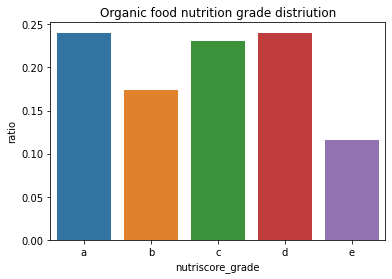

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Organic food nutrition grade distriution")
plt.show()

In [ ]:
# non-organic
sdf = spark.sql('''
SELECT nutriscore_grade, COUNT(*) AS cnt
FROM df_2
WHERE labels_en <> "Organic"
GROUP BY 1
ORDER BY 1
''')
sdf.show()
pdf = sdf.select('*').toPandas()

+----------------+-----+
|nutriscore_grade|  cnt|
+----------------+-----+
|               a|42840|
|               b|39924|
|               c|57491|
|               d|74856|
|               e|45693|
+----------------+-----+



sum 260804


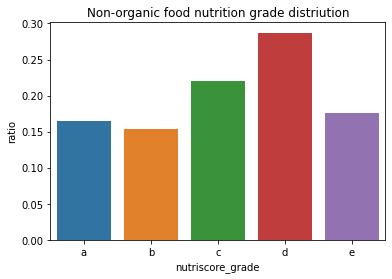

In [ ]:
s = pdf['cnt'].sum()
print('sum', s)
pdf['ratio'] = pdf['cnt'] / s
pdf
plt.figure()
ax = sns.barplot(data=pdf, x='nutriscore_grade', y='ratio')
plt.title("Non-organic food nutrition grade distriution")
plt.show()

Known from the results above, more than 40% of the the organic food products are in a or b, while there are around 30% of non-organic food products are in a or b grade. The difference of the ratio was not as much as we expected, but it is still the fact we got from the dataset that organic food is more likely to be in better nutrition grades in genreal.


1.3 Organic food common nutriants average value vs. non-organic food.

In [ ]:
# calculate the average value for each nutrient in orgnic food and non-organic food respectively
sdf = spark.sql('''
SELECT
    CASE
        WHEN labels_en = "Organic" THEN "Organic"
        ELSE "Non-organic"
    END AS type_of_food,
    AVG(`energy_100g`) AS `Avg_energy_100g`,
    AVG(`fat_100g`) AS `Avg_fat_100g`,
    AVG(`saturated-fat_100g`) AS `Avg_saturated-fat_100g`,
    AVG(`trans-fat_100g`) As `Avg_trans-fat_100g`,
    AVG(`cholesterol_100g`) AS `Avg_cholesterol_100g`,
    AVG(`carbohydrates_100g`) AS `Avg_carbohydrates_100g`,
    AVG(`sugars_100g`) AS `Avg_sugars_100g`,
    AVG(`fiber_100g`) AS `Avg_fiber_100g`,
    AVG(`proteins_100g`) AS `Avg_proteins_100g`,
    AVG(`salt_100g`) AS `Avg_salt_100g`,
    AVG(`sodium_100g`) AS `Avg_sodium_100g`,
    AVG(`vitamin-a_100g`) AS `Avg_vitamin-a_100g`,
    AVG(`vitamin-c_100g`) AS `Avg_vitamin-c_100g`,
    AVG(`calcium_100g`) AS `Avg_alcium_100g`,
    AVG(`iron_100g`) AS `Avg_iron_100g`,
    AVG(`fruits-vegetables-nuts-estimate-from-ingredients_100g`) AS `Avg_fruits-vegetables-nuts_100g`
FROM df_2
GROUP BY 1 
''')
pdf = sdf.select('*').toPandas()
pdf

,type_of_food,Avg_energy_100g,Avg_fat_100g,Avg_saturated-fat_100g,Avg_trans-fat_100g,Avg_cholesterol_100g,Avg_carbohydrates_100g,Avg_sugars_100g,Avg_fiber_100g,Avg_proteins_100g,Avg_salt_100g,Avg_sodium_100g,Avg_vitamin-a_100g,Avg_vitamin-c_100g,Avg_alcium_100g,Avg_iron_100g,Avg_fruits-vegetables-nuts_100g
0,Organic,1084.076363,13.197672,4.412415,0.003700,0.014565,27.920614,12.026638,4.051447,6.970236,0.994548,0.397828,0.110052,0.012105,1.003091e-01,0.004508,13.760239
1,Non-organic,106443.520490,100174.469824,100170.093762,0.070199,42515.550483,101165.731397,101125.766442,183068.587388,100182.634189,100098.592237,40039.436907,0.538259,41.473933,5.222850e+08,0.014250,9.054198


In [ ]:
# caculate and compare the ratio of nutrition grades for organic and non-organic food 
nutritions = []
types = []
amounts = []
for i, c in enumerate(pdf.columns):
    if i == 0:
        continue
    row = pdf[c]
    nutritions.append(c)
    max_value = max(row[0], row[1])
    types.append('Organic')
    amounts.append(1.0 * row[0] / max_value)
    amounts.append(1.0 * row[0] / max_value)
    nutritions.append(c)
    types.append('Non organic')
    amounts.append(1.0 * row[1] / max_value)

In [ ]:
import pandas as pd
graph_df = pd.DataFrame({"Nutrition": nutritions, "Type": types, 'Amount': amounts})

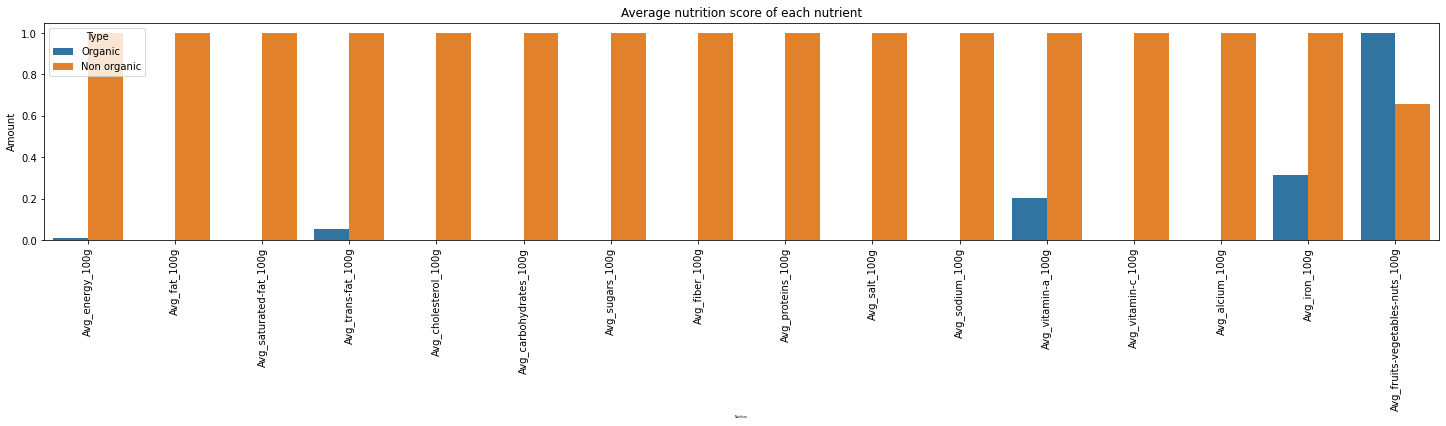

In [ ]:
# Visualize the comparison of organic and non-organic food for the average amount of each nutrient
plt.figure(figsize=(25,4))
ax = sns.barplot(data=graph_df, x='Nutrition', y='Amount', hue='Type')
ax.set_xlabel('Nutrition', fontsize=3)
plt.xticks(rotation=90)
plt.title('Average nutrition score of each nutrient')
plt.show()

(The numbers above look weird... need to check)

## 2.2 Additives and nutrition score/grade (Baojia & Wesley)

Many people care about if a food product contains additives since in commen sense, the more addtives the less heathy the food is. We studied the dataset to see if there is a correlation between the number of additives in a food product and its nutrition score/grade.

In [ ]:
sdf = spark.sql('''
SELECT CAST(additives_n AS INT) AS num_additives, AVG(nutriscore_score) AS score FROM data
GROUP BY 1
ORDER BY 1 ASC
''')
pdf = sdf.select('*').toPandas()
pdf

,num_additives,score
0,NaN,9.134879
1,0.0,5.249982
2,1.0,9.715077
3,2.0,11.656294
4,3.0,11.456494
5,4.0,12.639004
6,5.0,12.304157
7,6.0,12.518868
8,7.0,12.087952
9,8.0,12.708567


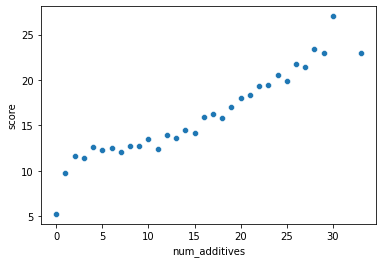

In [ ]:
plt.figure()
ax = sns.scatterplot(data=pdf, x='num_additives', y='score')
plt.show()

The results above shown a trend that the more number of additives are found in the food product the higher score (lower grade) the food has.

## 2.3 Source of nutritions (Baojia)

We wanted to know which food categories can certain provide specific nutrients, then we can live a heathier life by making smart choices on food selection based on our needs.

In [ ]:
# explode the food group column (as food category information)
from pyspark.sql.functions import split, col
df_3 = new_df.select('*', split(col("food_groups_en"),",").alias("food_groups_array"))
df_3.printSchema()
df_3.show()

root
 |-- code: string (nullable = true)
 |-- url: string (nullable = true)
 |-- creator: string (nullable = true)
 |-- created_t: string (nullable = true)
 |-- created_datetime: string (nullable = true)
 |-- last_modified_t: string (nullable = true)
 |-- last_modified_datetime: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- generic_name: string (nullable = true)
 |-- quantity: string (nullable = true)
 |-- packaging: string (nullable = true)
 |-- packaging_tags: string (nullable = true)
 |-- packaging_en: string (nullable = true)
 |-- brands: string (nullable = true)
 |-- brands_tags: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- categories_tags: string (nullable = true)
 |-- categories_en: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- labels: string (nullable = true)
 |-- labels_tags: string (nullable = true)
 |-- labels_en: string (nullabl

In [ ]:
# explode the food group column to get the food category for each products. Some food products belong to multiple categories.
from pyspark.sql.functions import explode
df_3 = df_3.select('*', explode(df_3.food_groups_array).alias('food_group'))

In [ ]:
# Select nutrients that people like to take supplements for as targe nutrients in our study.
# create a dictionary to store index and food category in order of the contained amount of each nutrient. 
# The smaller the index number, the higher value of the nutrient contained in the category.
df_3.createOrReplaceTempView("df_3")
pdfs = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
    sdf = spark.sql('''
    SELECT food_group, AVG(`{}`) AS amount
    FROM df_3
    GROUP BY 1
    ORDER BY amount DESC
    '''.format(s))
    pdfs[s] = sdf.toPandas()

In [ ]:
# sum the index of each food category over all nutrients. A smaller sum indicates the food category can provide more various of nutrients. 
# Just to note, since we didn't include the specific amounts of nutrients contained in each category into calculation and the index cannot fully represent how good or bad source a category is,
# the order just showed a tendency but is not a serious order of good sources of nutrients.
counter_dict = {}
for s in ['fiber_100g', 'proteins_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g']:
# for s in ['energy_100g']:
    for index, row in pdfs[s].iterrows():
        # print(row['food_group'], row['amount'])
        food_group = row['food_group']
        if food_group in counter_dict:
            counter_dict[food_group] += index
        else:
            counter_dict[food_group] = index
dict(sorted(counter_dict.items(), key=lambda item: item[1]))

{'Breakfast cereals': 29,
 'Milk and dairy products': 81,
 'Dried fruits': 82,
 'Cheese': 87,
 'Cereals and potatoes': 93,
 'Pastries': 93,
 'Nuts': 98,
 'Cereals': 101,
 'Salty snacks': 102,
 'Salty and fatty products': 106,
 'Vegetables': 108,
 'Artificially sweetened beverages': 111,
 'Fruits and vegetables': 112,
 'Fish and seafood': 116,
 'One-dish meals': 121,
 'Composite foods': 121,
 'Chocolate products': 128,
 'Sandwiches': 128,
 'Fish‚ Meat‚ Eggs': 128,
 'Sugary snacks': 140,
 'Biscuits and cakes': 141,
 'Fatty fish': 142,
 'Milk and yogurt': 143,
 'Legumes': 145,
 'Fats': 150,
 'Beverages': 150,
 'Potatoes': 152,
 'Fruit juices': 159,
 'Sweets': 160,
 'Unsweetened beverages': 162,
 'Pizza pies and quiches': 167,
 'Dairy desserts': 167,
 'Bread': 171,
 'Appetizers': 175,
 'Fruits': 176,
 'Fats and sauces': 180,
 'Sweetened beverages': 183,
 'Meat other than poultry': 188,
 'Processed meat': 191,
 'Meat': 193,
 'Plant-based milk substitutes': 195,
 'Dressings and sauces': 200,

## 2.4 High fat foods and countries (Preprocessing and EDA)(Raman)

Is it true that food in the US is less healthy due to a common stereotype that US food products contain more fats as compared to European food products?

Lets explore this question 

In [ ]:
new_df.createOrReplaceTempView("sdf")

In [ ]:
sql_q = spark.sql('''
select countries_en, 
cast(fat_100g as float) fat_100g, 
cast(`saturated-fat_100g` as float) `saturated-fat_100g`,
cast(`trans-fat_100g` as float) as `trans-fat_100g`,
 ingredients_text, 
cast( `cholesterol_100g` as float) as `cholesterol_100g`, 
cast( `carbohydrates_100g` as float) as `carbohydrates_100g`,
cast( `sugars_100g` as float) as `sugars_100g`, 
cast( `energy_100g` as float) as `energy_100g`
from sdf
where countries_en in ('United States', 'France', 'Italy', 'Germany', 'Belgium', 'Spain', 'Denmark', 'Switzerland')
''')

In [ ]:
df = sql_q.select('*').toPandas()

In [ ]:
df.shape

(2074985, 9)

In [ ]:
df.head()

,countries_en,fat_100g,saturated-fat_100g,trans-fat_100g,ingredients_text,cholesterol_100g,carbohydrates_100g,sugars_100g,energy_100g
0,France,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
1,Germany,2.0,2.00,NaN,None,NaN,65.000000,12.6,690.0
2,Spain,1.4,0.90,NaN,"Leche semidesnatada, azucar 6.9%, leche desnat...",NaN,9.800000,9.8,NaN
3,France,0.2,0.10,NaN,None,NaN,3.900000,3.9,238.0
4,France,7.0,3.08,NaN,None,NaN,70.099998,15.0,1569.0


In [ ]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})

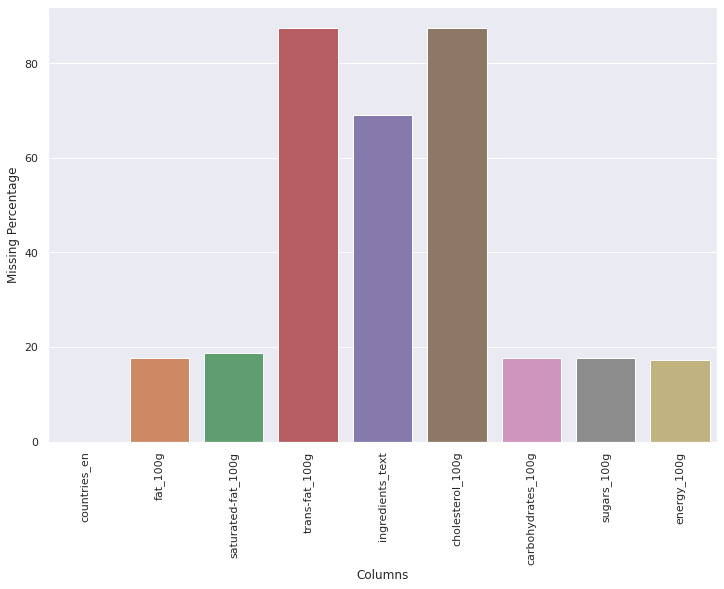

In [ ]:
ax = sns.barplot(data=missing_value_df, x="column_name", y="percent_missing")
ax.set(xlabel = "Columns", ylabel = "Missing Percentage")
ax.tick_params(axis='x', rotation=90)

In [ ]:
df.dtypes

countries_en           object
fat_100g              float32
saturated-fat_100g    float32
trans-fat_100g        float32
ingredients_text       object
cholesterol_100g      float32
carbohydrates_100g    float32
sugars_100g           float32
energy_100g           float32
dtype: object

[(-10.0, 65.0)]

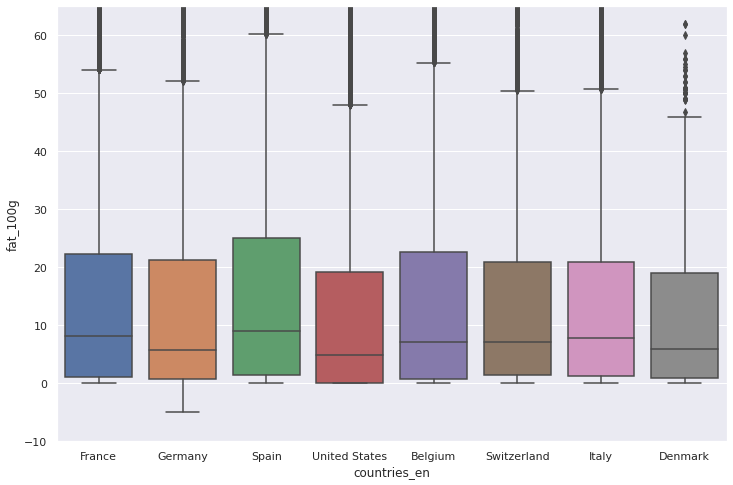

In [ ]:
# Using boxplot to visulaize the distribution of fat_100g by country
ax = sns.boxplot(x='countries_en', y='fat_100g', data=df)
ax.set(ylim=(-10, 65))

This is an interesting trend that US has one of the lowest median fat level per 100gms of food and US is still known as one of the most obese nations. While doing some literature search, I found that this trend has been already documented. For example this research mentioned this trend(Wansink, B., & Chandon, P. (2006). Can “Low-Fat” Nutrition Labels Lead to Obesity? Journal of Marketing Research, 43(4), 605–617. https://doi.org/10.1509/jmkr.43.4.605) .

[(-1.0, 20.0)]

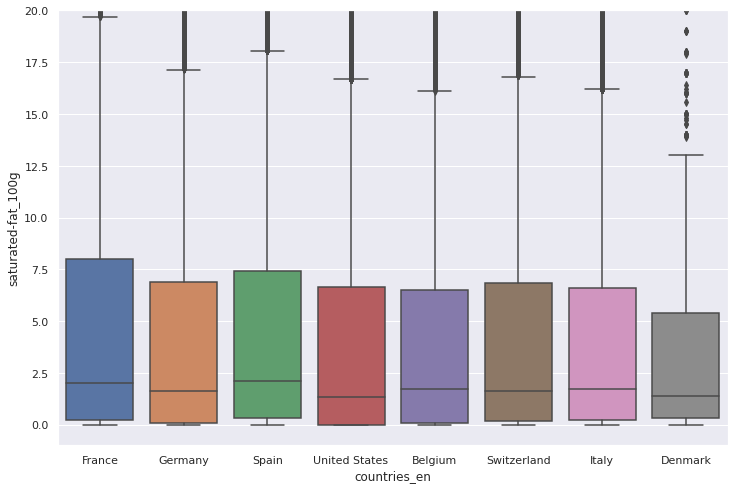

In [ ]:
# Using boxplot to visulaize the distribution of fat_100g by country
ax = sns.boxplot(x='countries_en', y='saturated-fat_100g', data=df)
ax.set(ylim=(-1, 20))

## 2.5 Top 10 Countries with almond containing products

While discussion with some families, it was interesting to learn abount Almost industry in the USA. I was curious to explore what proportion od US products contain almonds and how does it compare with other europeon countries.

Caution: Ingredient text is highly missing (~70%) in data so please interpret the results carefully.

In [ ]:
df['has_almonds'] = df.ingredients_text.str.contains('almond', case = False)

[Text(0, 0.5, 'Percentage of Products Contain Almonds'),
 Text(0.5, 0, 'Countries')]

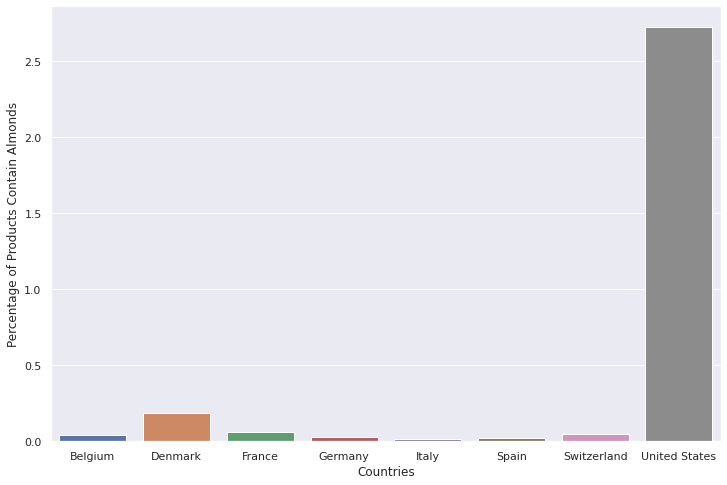

In [ ]:
df['has_almonds'].fillna(False, inplace=True)
n_almonds = pd.DataFrame({'n_almonds' : df.groupby('countries_en')['has_almonds'].sum(), 'total' : df.groupby('countries_en')['has_almonds'].count()}).reset_index()
n_almonds['pencentage_almonds'] = n_almonds['n_almonds']*100/n_almonds['total']
ax = sns.barplot(data=n_almonds, x="countries_en", y="pencentage_almonds")
ax.set(xlabel = "Countries", ylabel = "Percentage of Products Contain Almonds")

Given the high missingness, I wont try to over-interpret the results. However, if we assume that missingness is totally random, we can state that US has highes proportion of products with almonds. 

Interpretation of US data: About 2.75% of all products in this database in USA contain Almonds.

*Please note that the y axis is in percentage. So there is not no need to normalize the data*. 

### Modeling / Machine Learning (Raman)

Next we will try to find food clusters based on energy (calories), fats, carbohydrates, cholesterol, and sugars. I selected these variables because the general percention is that these variables are most closely associated obesity.

However, we noticed that trans fat and cholesterol variables are highly missing (>80) so we will not be able to use these variables.

#### Missing data handling

In [ ]:
km_df = df[['fat_100g', 
                   'saturated-fat_100g', 
          'carbohydrates_100g', 
                   'sugars_100g',
                  'energy_100g']]

In [ ]:
km_df.shape

(2074985, 5)

In [ ]:
percent_missing = km_df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': km_df.columns,
                                 'percent_missing': percent_missing})

In [ ]:
missing_value_df

,column_name,percent_missing
fat_100g,fat_100g,17.635742
saturated-fat_100g,saturated-fat_100g,18.810353
carbohydrates_100g,carbohydrates_100g,17.632995
sugars_100g,sugars_100g,17.691260
energy_100g,energy_100g,17.232462


Missingness is around 20% in remaining variables

Lets remove records with missing values


In [ ]:
km_df.dropna(inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
km_df

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
1,2.000000,2.00,65.000000,12.60,690.0
3,0.200000,0.10,3.900000,3.90,238.0
4,7.000000,3.08,70.099998,15.00,1569.0
7,11.000000,3.90,5.700000,0.05,812.0
8,15.100000,6.10,2.600000,1.00,3661.0
...,...,...,...,...,...
2074975,20.200001,6.00,30.900000,10.40,1393.0
2074977,7.600000,4.80,35.000000,24.00,925.0
2074978,5.000000,2.30,0.000000,0.00,548.0
2074981,0.300000,0.00,2.400000,0.60,100.0


We lost ~20% of data which is manageable.

Let see if we have any highly correlated variables

In [ ]:
km_df.corr()

,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,energy_100g
fat_100g,1.000000,0.413452,4.943116e-01,0.494284,5.485886e-03
saturated-fat_100g,0.413452,1.000000,6.219806e-01,0.620926,7.064182e-04
carbohydrates_100g,0.494312,0.621981,1.000000e+00,0.999998,8.932304e-07
sugars_100g,0.494284,0.620926,9.999982e-01,1.000000,3.028139e-06
energy_100g,0.005486,0.000706,8.932304e-07,0.000003,1.000000e+00


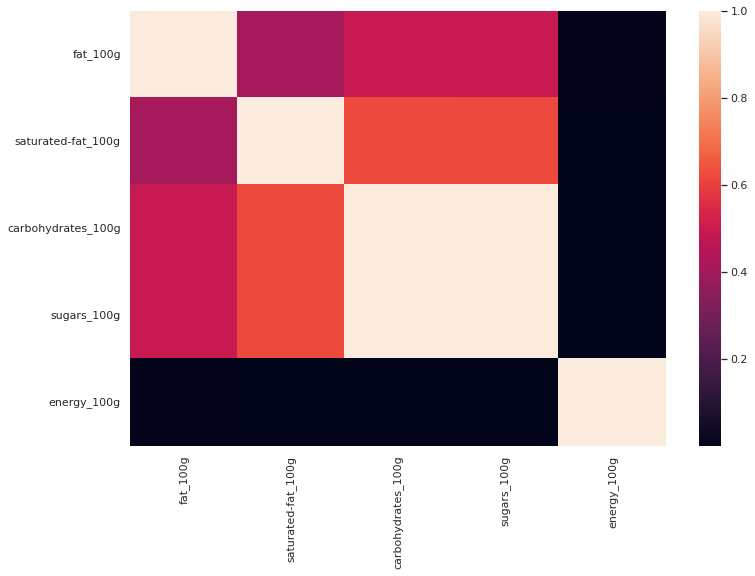

In [ ]:
sns.heatmap(km_df.corr())

I see energy is highly correlated with all variables, which makes sense. We can drop this variable.

In [ ]:
km_df.drop('energy_100g', axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


KMeans is not a scale invariant model so we need to standardize our dataset

In [ ]:
from sklearn.preprocessing import scale
X_scaled = scale(km_df)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


First lets find out how many clusters best explain the data.

In [ ]:
from sklearn.cluster import KMeans
ssd = []
for k in range(1,11):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(X_scaled)
    ssd.append(kmeans.inertia_)

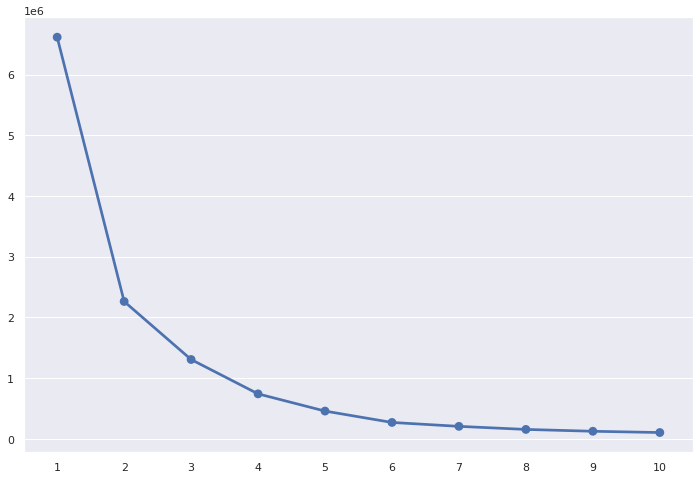

In [ ]:
sns.pointplot(y = ssd, x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Based on this plot and using the Elbow Method the best number of clusters to is 6

In [ ]:
kmeans = KMeans(n_clusters = 6, random_state = 1).fit(X_scaled)

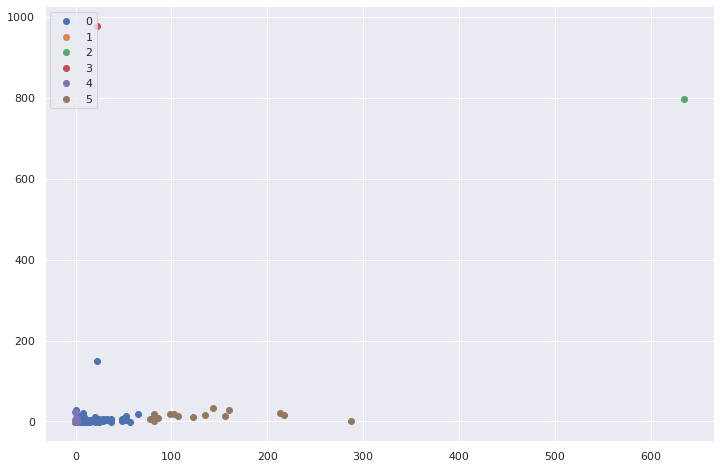

In [ ]:
label = kmeans.fit_predict(X_scaled)
 
u_labels = np.unique(label)
 
for i in u_labels:
    plt.scatter(X_scaled[label == i , 0] , X_scaled[label == i , 1] , label = i)
plt.legend()
plt.show()

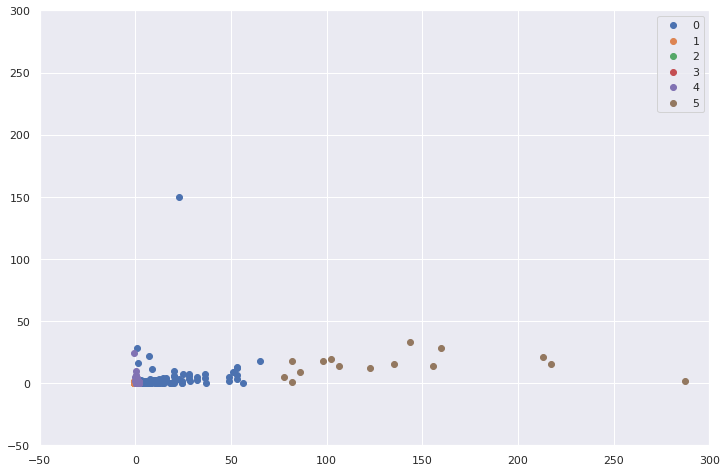

In [ ]:
for i in u_labels:
    plt.scatter(X_scaled[label == i , 0] , X_scaled[label == i , 1] , label = i)
plt.legend()
plt.ylim((-50,300))
plt.xlim((-50, 300))
plt.show()

In [ ]:
km_df['cluster'] = label

<ipython-input-67-c8b8da4e10e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km_df['cluster'] = label


1          1
3          1
4          1
7          1
8          1
          ..
2074975    4
2074977    1
2074978    1
2074981    1
2074983    4
Name: cluster, Length: 1650023, dtype: int32

# 3 Feature Engineering (Baojia)

By learning about how nutriscore was calculated, we know there are some features count as positive and others are negative. Also, beverage and solid food were calculated in different ways. We genreate our features based on the facts we learned from the following resources:

https://www.frontiersin.org/articles/10.3389/fnut.2022.974003/full


In [ ]:
# drop colums that contain null in 'nutrisocre_score' or 'nutriscore_grade' columns.
df = df.filter(df.nutriscore_grade.isNotNull() | df.nutriscore_score.isNotNull())

In [ ]:
# drop colums that are not needed in the modeling 
cols_to_drop = [
    'url',
    'creator',
    'created_t',
    'created_datetime',
    'last_modified_t',
    'last_modified_datetime',
    'abbreviated_product_name',
    'generic_name',
    'quantity',
    'packaging',
    'packaging_tags',
    'packaging_en',
    'packaging_text',
    'brands',
    'brands_tags',
    'categories',
    'categories_en',
    'origins',
    'origins_tags',
    'origins_en',
    'manufacturing_places',
    'manufacturing_places_tags',
    'labels',
    'labels_tags',
    'labels_en',
    'emb_codes',
    'emb_codes_tags',
    'first_packaging_code_geo',
    'cities',
    'cities_tags',
    'purchase_places',
    'stores',
    'countries',
    'countries_tags',
    'ingredients_text',
    'ingredients_tags',
    'ingredients_analysis_tags',
    'allergens',
    'allergens_en',
    'traces',
    'traces_tags',
    'traces_en',
    'serving_size',
    'serving_quantity',
    'no_nutriments',
    'additives',
    'additives_tags',
    'additives_en',
    'nova_group',
    'pnns_groups_1',
    'pnns_groups_2',
    'food_groups',
    'food_groups_tags',
    'states',
    'states_tags',
    'states_en',
    'brand_owner',
    'ecoscore_grade',
    'ecoscore_score',
    'nutrient_levels_tags',
    'product_quantity',
    'owner',
    'data_quality_errors_tags',
    'unique_scans_n',
    'popularity_tags',
    'completeness',
    'last_image_t',
    'last_image_datetime',
    'main_category',
    'image_url',
    'image_small_url',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'carbon-footprint_100g',
    'carbon-footprint-from-meat-or-fish_100g',
    'nutrition-score-fr_100g',
    'nutrition-score-uk_100g',
]
df_train = df.drop(*cols_to_drop)



In [ ]:
# Save the training data into a temp file and read from it to save memory
import pyarrow.parquet as pq
df_train.repartition(1).write.mode('overwrite').parquet('tmp/data')

In [ ]:
df_train = pd.read_parquet('tmp/data')
df_train

,code,product_name,categories_tags,countries_en,additives_n,nutriscore_score,nutriscore_grade,food_groups_en,main_category_en,energy-kj_100g,...,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000026772226,Skyr,"en:dairies,en:desserts,en:fermented-foods,en:f...",France,None,-5,a,"Milk and dairy products,Dairy desserts",Cream cheeses,None,...,None,None,None,None,None,None,None,None,None,None
1,0000000000100,moutarde au moût de raisin,"en:condiments,en:sauces,en:mustards,en:groceries",France,0,18,d,"Fats and sauces,Dressings and sauces",Groceries,936,...,None,None,None,None,None,None,None,None,None,None
2,000000000080,Pur jus de pomme,"en:plant-based-foods-and-beverages,en:beverage...",France,None,9,d,"Beverages,Fruit juices",Squeezed apple juices,None,...,None,None,None,None,None,None,None,None,None,None
3,0000000000949,Salade de carottes râpées,"en:plant-based-foods-and-beverages,en:plant-ba...",France,None,1,b,"Composite foods,One-dish meals",Seasoned grated carrots,None,...,None,None,None,None,None,None,None,None,None,None
4,0000000001281,Tarte noix de coco,"en:sweet-pies,en:pies,en:coconut-pies",France,None,14,d,"Composite foods,Pizza pies and quiches",Coconut pies,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833365,9999991149090,Riz parfumé,"en:plant-based-foods-and-beverages,en:plant-ba...",France,None,0,b,"Cereals and potatoes,Cereals",Aromatic rices,None,...,None,None,None,None,None,None,None,None,None,None
833366,9999999004360,Minis beignets,"en:snacks,en:sweet-snacks,en:sweet-fritters",France,None,15,d,None,Sweet Fritters,None,...,None,None,None,None,None,None,None,None,None,None
833367,9999999175305,Erdbeerkuchen 1019g tiefgefroren,"en:snacks,en:sweet-snacks,en:biscuits-and-cake...",Germany,2,12,d,"Sugary snacks,Biscuits and cakes",de:tiefkühl-kuchen,925,...,None,None,None,None,None,None,None,None,None,None
833368,99999995,Steak haché 5%,"en:meats,en:beef,en:meat-patties,en:boeuf,en:s...",France,0,-2,a,"Fish‚ Meat‚ Eggs,Meat,Meat other than poultry",Viandes,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
string_columns = ['code', 'product_name', 'categories_tags', 'countries_en', 'nutriscore_grade', 'food_groups_en', 'main_category_en'] 
float_columns = list(set(df_train.columns) - set(string_columns))
for column in float_columns:
    df_train[column] = df_train[column].astype('float')

# 4 Modeling (Baojia)

In [ ]:
import statsmodels.api as sm

X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n']]
X = X.fillna(0)
y = df_train['nutriscore_score']

In [ ]:
# remove outlier, plot distribution
def remove_outlier(X):
    X['energy_100g'] = X['energy_100g'].clip(upper=4000)
    for c in X.columns:
        if 'energy' not in c:
            X[c] = X[c].clip(upper=100)
remove_outlier(X)

In [ ]:
# check the distribution of some features
X

,sodium_100g,energy_100g,fat_100g,sugars_100g,proteins_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,fiber_100g,carbohydrates_100g
0,0.036,238.0,0.2,3.9,10.0,0.0,0.0,3.9
1,1.840,936.0,8.2,22.0,5.1,0.0,0.0,29.0
2,0.000,264.0,0.0,15.5,0.2,0.0,0.0,15.5
3,0.168,134.0,0.3,3.9,0.9,0.0,0.0,5.3
4,0.040,1594.0,22.0,21.9,4.6,0.0,4.4,27.3
...,...,...,...,...,...,...,...,...
833365,0.000,1469.0,0.5,0.0,7.0,0.0,0.0,80.0
833366,0.440,1393.0,20.2,10.4,7.4,0.0,0.0,30.9
833367,0.112,925.0,7.6,24.0,2.6,12.0,0.0,35.0
833368,0.072,548.0,5.0,0.0,21.5,0.0,0.0,0.0


In [ ]:
def train_model(x, y):
    x_train_with_constant = sm.add_constant(x)
    model = sm.OLS(y, x_train_with_constant)
    model = model.fit()
    y_pred = model.predict(x_train_with_constant)
    print(np.round(np.sqrt(np.sum(((np.array(y_pred)-np.array(y))**2))/len(y_pred)),2))
    return model
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


5.35


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                 1.234e+05
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:26:45   Log-Likelihood:            -2.5797e+06
No. Observations:              833370   AIC:                         5.160e+06
Df Residuals:                  833358   BIC:                         5.160e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     1.5715      0.013    123.910      0.000       1.547       1.596
salt_100g                                                 0.6900      0.004    186.672      0.000       0.683       0.697
sodium_100g                                              -0.6364      0.006    -99.466      0.000      -0.649      -0.624
energy_100g                                               0.0031   2.48e-05    123.529      0.000       0.003       0.003
fat_100g                                                  0.0110      0.001     10.897      0.000       0.009       0.013
saturated-fat_100g                                        0.3606      0.001    348.770      0.000       0.359       0.363
sugars_100g                                               0.1991      0.000    445.059      0.000       0.198       0.200
proteins_100g                                             0.0466      0.001     59.666      0.000       0.045       0.048
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0593      0.000   -183.184      0.000      -0.060      -0.059
fiber_100g                                               -0.3963      0.002   -244.072      0.000      -0.399      -0.393
carbohydrates_100g                                       -0.0333      0.001    -66.223      0.000      -0.034      -0.032
additives_n                                               0.3843      0.002    166.228      0.000       0.380       0.389
==============================================================================
Omnibus:                    31443.069   Durbin-Watson:                   1.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            82407.041
Skew:                          -0.170   Prob(JB):                         0.00
Kurtosis:                       4.503   Cond. No.                     3.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X = df_train[['salt_100g', 'sodium_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'proteins_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g', 'fiber_100g', 'carbohydrates_100g', 'additives_n', 'fruits-vegetables-nuts-estimate_100g', 'fruits-vegetables-nuts_100g']]
y = df_train['nutriscore_score']
X['is_beverage'] = 0
# X['is_juice'] = 0
X['is_oil'] = 0
X['contains_fruit'] = 0
X['is_fats'] = 0
# X['is_snack'] = 0
# X['is_milk'] = 0
# X['is_coffee'] = 0
# X['is_tea'] = 0
X['is_water'] = 0
# X['is_cheese'] = 0
# X['saturated_fat_ratio'] = df_train['saturated-fat_100g'] / df_train['fat_100g']
X = X.fillna(0)
X.loc[df_train['categories_tags'].str.contains('en:beverages', na=False), 'is_beverage'] = 1
# X.loc[df_train['categories_tags'].str.contains('juice', na=False), 'is_juice'] = 1
X.loc[df_train['categories_tags'].str.contains('oil', na=False), 'is_oil'] = 1
X.loc[df_train['categories_tags'].str.contains('fruit', na=False), 'contains_fruit'] = 1
X.loc[df_train['categories_tags'].str.contains('en:fats', na=False), 'is_fats'] = 1
# X.loc[df_train['categories_tags'].str.contains('snack', na=False), 'is_snack'] = 1
# X.loc[df_train['categories_tags'].str.contains('milk', na=False), 'is_milk'] = 1
# X.loc[df_train['categories_tags'].str.contains('coffee', na=False), 'is_coffee'] = 1
# X.loc[df_train['categories_tags'].str.contains('tea', na=False), 'is_tea'] = 1
X.loc[df_train['categories_tags'].str.contains('en:spring-waters', na=False), 'is_water'] = 1
# X.loc[df_train['categories_tags'].str.contains('cheese', na=False), 'is_cheese'] = 1




<ipython-input-86-28ca4812c19f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_beverage'] = 0
<ipython-input-86-28ca4812c19f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['is_oil'] = 0
<ipython-input-86-28ca4812c19f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [ ]:
remove_outlier(X)
model = train_model(X, y)
model.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


4.74


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       nutriscore_score   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 1.087e+05
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        00:53:26   Log-Likelihood:            -2.4790e+06
No. Observations:              833370   AIC:                         4.958e+06
Df Residuals:                  833351   BIC:                         4.958e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                                     0.5881      0.013     43.774      0.000       0.562       0.614
salt_100g                                                 0.6931      0.003    210.941      0.000       0.687       0.700
sodium_100g                                              -0.6401      0.006   -112.776      0.000      -0.651      -0.629
energy_100g                                               0.0036   2.21e-05    162.098      0.000       0.004       0.004
fat_100g                                                  0.1020      0.001    109.785      0.000       0.100       0.104
saturated-fat_100g                                        0.3247      0.001    344.580      0.000       0.323       0.327
sugars_100g                                               0.1902      0.000    473.717      0.000       0.189       0.191
proteins_100g                                             0.0087      0.001     11.910      0.000       0.007       0.010
fruits-vegetables-nuts-estimate-from-ingredients_100g    -0.0525      0.000   -172.247      0.000      -0.053      -0.052
fiber_100g                                               -0.4137      0.001   -286.458      0.000      -0.417      -0.411
carbohydrates_100g                                       -0.0347      0.000    -77.183      0.000      -0.036      -0.034
additives_n                                               0.3334      0.002    161.204      0.000       0.329       0.337
fruits-vegetables-nuts-estimate_100g                      0.0026      0.001      3.111      0.002       0.001       0.004
fruits-vegetables-nuts_100g                              -0.0126      0.001    -13.685      0.000      -0.014      -0.011
is_beverage                                               5.9458      0.022    273.405      0.000       5.903       5.988
is_oil                                                   -3.7892      0.043    -88.889      0.000      -3.873      -3.706
contains_fruit                                           -1.5934      0.019    -85.603      0.000      -1.630      -1.557
is_fats                                                 -13.9260      0.048   -288.343      0.000     -14.021     -13.831
is_water                                                 -6.4281      0.079    -81.315      0.000      -6.583      -6.273
==============================================================================
Omnibus:                    42010.732   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           144961.300
Skew:                          -0.149   Prob(JB):                         0.00
Kurtosis:                       5.021   Cond. No.                     2.16e+04
====

In [ ]:
from sklearn.model_selection import train_test_split

# TO-DO: Conduct 80/20 train-test split with random_state = 42
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.20)

# Apply normalization, StandardScaler doesn't work
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)

from sklearn.metrics import mean_squared_error
import math
y_pred = reg.predict(x_train)
print(mean_squared_error(y_train, y_pred))
print(math.sqrt(mean_squared_error(y_train, y_pred)))

22.477617204584547
4.7410565493974595


In [ ]:
y_pred = reg.predict(x_test)
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

22.353363160069506
4.72793434388312


In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=10)
clf = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_train)
print('train mse', mean_squared_error(y_train, y_pred))
print('train rmse', math.sqrt(mean_squared_error(y_train, y_pred)))

train mse 1.7802371935497894
train rmse 1.334255295492504


In [ ]:
y_pred = clf.predict(x_test)
print('test mse', mean_squared_error(y_test, y_pred))
print('test rmse', math.sqrt(mean_squared_error(y_test, y_pred)))

test mse 2.1905524591630163
test rmse 1.4800515055777674


# 5 Recommend a Better Alternative (Wesley)

# 6 Conclusion